In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install gsutil

     |████████████████████████████████| 2.5MB 5.6MB/s 
     |████████████████████████████████| 174kB 45.6MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 1.4MB 59.1MB/s 
     |████████████████████████████████| 112kB 58.4MB/s 
     |████████████████████████████████| 2.6MB 61.6MB/s 
  Created wheel for gsutil: filename=gsutil-4.55-cp36-none-any.whl size=3331428 sha256=9d77441a781da546421c404d3fcc74b0368d00c679893c8b0ea2027ab39307b9
  Stored in directory: /root/.cache/pip/wheels/70/f0/2f/ea4313bb5bca257451d401ea506ad7ac0e5b7a69969982bde2
  Created wheel for gcs-oauth2-boto-plugin: filename=gcs_oauth2_boto_plugin-2.7-cp36-none-any.whl size=23202 sha256=1bbaa911cecaa452023b1aa139762f8d7b097ff4baa9a42fc078160fd4980a0d
  Stored in directory: /root/.cache/pip/wheels/2e/6b/7c/bd86832ceb17e0ae3d362c44f461832452eeaacddfcf9128ee
  Created 

In [ ]:
!gsutil -m cp -r gs://eegmmidb-1.0.0.physionet.org ./

Copying gs://eegmmidb-1.0.0.physionet.org/64_channel_sharbrough.pdf...
Copying gs://eegmmidb-1.0.0.physionet.org/64_channel_sharbrough-old.png...
Copying gs://eegmmidb-1.0.0.physionet.org/64_channel_sharbrough.png...
Copying gs://eegmmidb-1.0.0.physionet.org/ANNOTATORS...
Copying gs://eegmmidb-1.0.0.physionet.org/SHA256SUMS.txt...
Copying gs://eegmmidb-1.0.0.physionet.org/RECORDS...
Copying gs://eegmmidb-1.0.0.physionet.org/eeg-motor-movementimagery-dataset-1.0.0.zip...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R01.edf...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R02.edf.event...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R02.edf...
Copying gs://eegmmidb-1.0.0.physionet.org/wfdbcal...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R01.edf.event...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R03.edf.event...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R05.edf.event...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R04.edf.event...
Copying 

In [ ]:
import os
os.chdir('eegmmidb-1.0.0.physionet.org')

def remove_file(file_loc):
  if os.path.exists(file_loc):
    os.remove(file_loc)
  else:
    print("The file does not exist")

file_remove_list = ["64_channel_sharbrough-old.png", "64_channel_sharbrough.pdf", "64_channel_sharbrough.png", "ANNOTATORS", "RECORDS", "SHA256SUMS.txt", "eeg-motor-movementimagery-dataset-1.0.0.zip","wfdbcal"]

for files in file_remove_list:
  remove_file(files)

In [ ]:
!pip install mne

     |████████████████████████████████| 6.8MB 5.8MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import os
import zipfile
import mne
import seaborn as sns

from tensorflow.keras.layers import Input, Dense, Multiply, Activation, Lambda, Reshape, BatchNormalization, LeakyReLU, Flatten, Dropout, Conv1D, MaxPooling1D, AveragePooling1D, concatenate, Add, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import backend as K
# from tensorflow.keras import metrics
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import Sequence, plot_model

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

from itertools import combinations

In [ ]:
def normalize_vector(vector):
  normalized_vector = (vector - vector.min()) / (vector.max() - vector.min())
  return normalized_vector

def preprocess(X):
  X = np.array(X)
  X = np.array([normalize_vector(i) for i in X], dtype=np.float)
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  return X

In [ ]:
def build_dataset(no_of_people=80):
  dataset = {}
  X = []
  Y = []
  folders = os.listdir(os.getcwd())
  for folder in folders[:no_of_people]:
    y = int(folder[-3:])-1
    count = 0
    for filename in os.listdir(os.getcwd()+'/'+folder):
      task_no = filename[5:7]
      folder_no = folder[1:]
      if filename.endswith("edf") and task_no != "01" and task_no != "02":
        edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)
        eeg = edf_file.get_data()
        if eeg.shape[1] > 15000:
          eeg = np.moveaxis(np.asarray(eeg, dtype=np.float64), 0, -1)
          data = eeg[:3000, :]
          data = np.array([normalize_vector(i) for i in data], dtype=np.float)
          X.append(data)
          Y.append(y)
      else:
        continue
  
  dataset['x'] = np.array(X)
  dataset['y'] = np.array(Y)
  return dataset

In [ ]:
dataset = build_dataset(no_of_people=109)

Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S097/S097R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S097/S097R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S097/S097R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S097/S097R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S097/S097R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S097/S097R14.edf...
EDF file detected
Setting channel info structure...

<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)
<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)
<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)
<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)


Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S100/S100R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S100/S100R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S100/S100R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S100/S100R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)
<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)
<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)
<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)


Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S100/S100R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S100/S100R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S100/S100R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S100/S100R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)
<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)
<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)
<ipython-input-8-3e1d69c8743c>:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  edf_file = mne.io.read_raw_edf(os.getcwd()+'/'+folder+'/'+filename)


Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S005/S005R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S005/S005R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S005/S005R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S005/S005R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S005/S005R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eegmmidb-1.0.0.physionet.org/S005/S005R10.edf...
EDF file detected
Setting channel info structure...

In [ ]:
print(dataset["x"].shape, dataset["y"].shape)

(1307, 3000, 64) (1307,)


In [ ]:
def build_csv_dataset(x, y, no_of_samples = 5):
  subject_dict = {}
  classes = np.unique(y)
  for subject in classes:
    subject_dict[subject] = []

  idx = [np.where(y == i)[0] for i in range(len(classes))]
  count = 0
  for subject_data in idx:
    for i in range(no_of_samples):
      for j in range(3000):
        subject_dict[count].append(x[subject_data[i],j,22])
    count += 1
  df = pd.DataFrame(data=subject_dict)
  df.to_csv('test_dataset_2.csv')

In [ ]:
build_csv_dataset(dataset["x"], dataset["y"], 5)

In [ ]:
def split_data(dataset, val_split = 0.2, test_split = 0.2, channel_index_start = 0, channel_index_end = 1):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  x_test = []
  y_test = []

  x = dataset["x"][:,:,channel_index_start:channel_index_end]
  y = dataset["y"]
  no_of_classes = len(np.unique(y))
  for i in range(no_of_classes):
    subject_idx = np.where(y == i)
    idx = subject_idx[0]

    val_count = int(val_split*len(idx))
    test_count = int(test_split*len(idx))
    
    val_idx = np.random.choice(idx, size=val_count, replace=False)
    for k in val_idx:
      idx = np.delete(idx, np.argwhere(idx == k))
    
    test_idx = np.random.choice(idx, size=test_count, replace=False)
    for k in test_idx:
      idx = np.delete(idx, np.argwhere(idx == k))

    for j in val_idx:
      x_val.append(x[j])
      y_val.append(y[j])
    
    for j in test_idx:
      x_test.append(x[j])
      y_test.append(y[j])
    
    for j in idx:
      x_train.append(x[j])
      y_train.append(y[j])
        
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_val, y_val = np.array(x_val), np.array(y_val)
  x_test, y_test = np.array(x_test), np.array(y_test)

  x_train, y_train = shuffle(x_train, y_train)
  x_val, y_val = shuffle(x_val, y_val)
  x_test, y_test = shuffle(x_test, y_test)

  return (x_train, y_train, x_val, y_val, x_test, y_test)
  

Use channel 22, 55 and 63

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(dataset, 0.4, 0.0, 22, 23)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(871, 3000, 1) (871,) (436, 3000, 1) (436,) (0,) (0,)


In [ ]:
def make_pairs(data, labels):
  pair_signals = []
  pair_subjects = []

  no_of_classes = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(0, no_of_classes)]

  for person in idx:
    positive_combinations = combinations(person, 2)
    for pair in positive_combinations:
      signal_1_idx = pair[0]
      signal_2_idx = pair[1] 
      current_signal = data[signal_1_idx]
      subject = labels[signal_1_idx]
      pos_signal = data[signal_2_idx]
      pair_signals.append([current_signal, pos_signal])
      # pair_subjects.append((1.0, subject))
      pair_subjects.append(1.0)

      neg_idx = np.where(labels != subject)[0]
      neg_signal = data[np.random.choice(neg_idx)]
      pair_signals.append([current_signal, neg_signal])
      # pair_subjects.append((0.0, subject))
      pair_subjects.append(0.0)
  
  # for idxA in range(len(data)):
  #   current_signal = data[idxA]
  #   subject = labels[idxA]
  #   idxB = np.random.choice(idx[subject])
  #   pos_signal = data[idxB]
  #   pair_signals.append([current_signal, pos_signal])
  #   pair_subjects.append(([1.0], subject))

  #   neg_idx = np.where(labels != subject)[0]
  #   neg_signal = data[np.random.choice(neg_idx)]
  #   pair_signals.append([current_signal, neg_signal])
  #   pair_subjects.append(([0.0], subject))

  return (np.array(pair_signals), np.array(pair_subjects))

In [ ]:
(pair_train, label_train) = make_pairs(x_train, y_train)
(pair_val, label_val) = make_pairs(x_val, y_val)
(pair_test, label_test) = make_pairs(x_test, y_test)

In [ ]:
print("Training data: ", pair_train.shape, label_train.shape)
print("Validation data: ", pair_val.shape, label_val.shape)
print("Testing data: ", pair_test.shape, label_test.shape)

Training data:  (6090, 2, 3000, 1) (6090,)
Validation data:  (1308, 2, 3000, 1) (1308,)
Testing data:  (0,) (0,)


# Resnet Model

In [ ]:
def residual_block(input, no_of_filters, kernel_size=3):
  x_short = Conv1D(filters=no_of_filters, kernel_size=1, kernel_regularizer=l2(2e-4), padding="same")(input)
  x_short = BatchNormalization()(x_short)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same", kernel_regularizer=l2(2e-4))(input)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same", kernel_regularizer=l2(2e-4))(x)
  x = BatchNormalization()(x)

  x_add = Add()([x_short, x])
  x_out = LeakyReLU(alpha=0.2)(x_add)
  return x_out

In [ ]:
def build_resnet(cnn_input):
  x = residual_block(cnn_input, 16, 3)
  x = MaxPooling1D(pool_size=2)(x)
  x = residual_block(x, 32, 3)
  x = MaxPooling1D(pool_size=2)(x)
  x = residual_block(x, 64, 3)
  x = MaxPooling1D(pool_size=2)(x)
  x = residual_block(x, 128, 3)
  x = GlobalAveragePooling1D()(x)
  return x

# Wavenet Model

In [ ]:
def residual_block_wavenet(n_filters, kernel_size, x, i):
  tanh_out = Conv1D(n_filters, 
                    kernel_size = kernel_size, 
                    dilation_rate = kernel_size**i, 
                    padding='causal', 
                    name='dilated_conv_%d_tanh' % (kernel_size ** i), 
                    activation='tanh'
                    )(x)
  sigm_out = Conv1D(n_filters, 
                    kernel_size  = kernel_size, 
                    dilation_rate = kernel_size**i, 
                    padding='causal', 
                    name='dilated_conv_%d_sigm' % (kernel_size ** i), 
                    activation='sigmoid'
                    )(x)
  z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
  skip = Conv1D(n_filters, 1, name='skip_%d'%(i))(z)
  res = Add(name='residual_block_%d' % (i))([skip, x])
  return res, skip


In [ ]:
def build_wavenet(cnn_input): 
  kernel_size = 2   
  dilation_depth = 6
  n_filters = 40
  skip_connections = []
  x = Conv1D(n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(cnn_input)
  
  for i in range(1, dilation_depth + 1):
    x, skip = residual_block_wavenet(n_filters, kernel_size, x, i)
    skip_connections.append(skip)
    
  x = Add(name='skip_connections')(skip_connections)
  x = Activation('relu')(x)
  
  x = Conv1D(n_filters, 80, strides = 1, padding='same', name='conv_5ms', activation = 'relu')(x)
  x = AveragePooling1D(80, padding='same', name='downsample_to_200Hz')(x)
  
  x = Conv1D(n_filters, 100, padding='same', activation='relu', name='conv_500ms')(x)
  
  x = Conv1D(128, 100, padding='same', activation='relu', name='conv_500ms_target_shape')(x)
  x = AveragePooling1D(100, padding='same',name = 'downsample_to_2Hz')(x)
  
  x = Conv1D(128, (1), padding='same', name='final_conv')(x)
  x = AveragePooling1D((1), name='final_pooling')(x)

  return x

# Model Building

In [ ]:
def euclidean_distance(vects):
  (p , q) = vects
  sum = K.square(p - q)
  return K.sqrt(K.maximum(sum, K.epsilon()))
 
def manhattan_distance(vects):
  (p, q) = vects
  return K.abs(p - q)

SQRT2 = K.sqrt(K.constant(2))

def hellinger_distance(vects):
  (p, q) = vects
  p, q = K.sqrt(p), K.sqrt(q)
  return K.square(p - q) / SQRT2

In [ ]:
def build_model(time_steps, features, model_type, distance_metric):
  model_types = {
    "resnet": build_resnet,
    "wavenet": build_wavenet,
  }

  distance_metrics = {
    "euclidean": euclidean_distance,
    "manhattan": manhattan_distance,
    "hellinger": hellinger_distance,
  }

  input_shape = (time_steps, features)

  # Siamese Input ----------------------------------------------------------------------------
  siamese_left_input = Input(shape=input_shape)
  siamese_right_input = Input(shape=input_shape)
  # ------------------------------------------------------------------------------------------

  # CNN --------------------------------------------------------------------------------------
  cnn_input = Input(shape=input_shape)
  x = model_types[model_type](cnn_input)
  
  x = Flatten()(x)
  cnn_output = Activation("sigmoid")(x)

  cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
  # -------------------------------------------------------------------------------------------

  # Siamese Output-----------------------------------------------------------------------------
  encoded_l = cnn_model(siamese_left_input)
  encoded_r = cnn_model(siamese_right_input)

  distance = Lambda(distance_metrics[distance_metric])([encoded_l, encoded_r])

  siamese_output = Dense(1, activation='sigmoid')(distance)
  siamese_net = Model(inputs=[siamese_left_input, siamese_right_input], outputs=siamese_output)
  # -------------------------------------------------------------------------------------------

  return siamese_net, cnn_model

In [ ]:
model, cnn_model = build_model(3000, 1, "resnet", "manhattan")
model.summary()
cnn_model.summary()

Model: "functional_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
input_47 (InputLayer)           [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
functional_57 (Functional)      (None, 128)          111952      input_46[0][0]                   
                                                                 input_47[0][0]                   
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 128)          0           functional_57[0][0]  

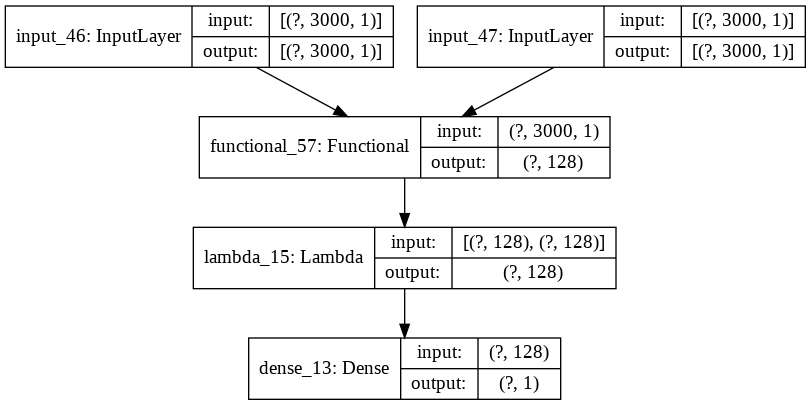

In [ ]:
plot_model(model, to_file='./model.png', show_shapes=True, show_layer_names=True)

In [ ]:
INIT_LR = 0.0005
EPOCHS = 20
BATCH_SIZE = 16
STEPS_PER_EPOCH = pair_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = pair_val.shape[0] // BATCH_SIZE

def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0

  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

callbacks = [LearningRateScheduler(poly_decay)]
opt = Adam(lr=INIT_LR, amsgrad=True)

In [ ]:
def contrastive_loss(y_true, y_pred):
  margin = 1.0
  return K.mean(y_true * K.square(y_pred) + (1.0 - y_true) * K.square(K.maximum(margin - y_pred, 0.0)))

def custom_acc(y_true, y_pred):
  return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[custom_acc])

In [ ]:
r = model.fit(
  [pair_train[:, 0], pair_train[:, 1]], label_train[:],
  validation_data = ([pair_val[:, 0], pair_val[:, 1]], label_val[:]),
  batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks,
)

Epoch 1/20
381/381 [==============================] - 10s 26ms/step - loss: 0.3017 - custom_acc: 0.6095 - val_loss: 0.2832 - val_custom_acc: 0.6463
Epoch 2/20
381/381 [==============================] - 10s 26ms/step - loss: 0.2605 - custom_acc: 0.6981 - val_loss: 0.2477 - val_custom_acc: 0.7317
Epoch 3/20
381/381 [==============================] - 9s 24ms/step - loss: 0.2354 - custom_acc: 0.7383 - val_loss: 0.2309 - val_custom_acc: 0.7304
Epoch 4/20
381/381 [==============================] - 9s 24ms/step - loss: 0.2184 - custom_acc: 0.7627 - val_loss: 0.2227 - val_custom_acc: 0.7607
Epoch 5/20
381/381 [==============================] - 9s 25ms/step - loss: 0.2024 - custom_acc: 0.7906 - val_loss: 0.1941 - val_custom_acc: 0.8189
Epoch 6/20
381/381 [==============================] - 9s 24ms/step - loss: 0.1922 - custom_acc: 0.8040 - val_loss: 0.1979 - val_custom_acc: 0.8018
Epoch 7/20
381/381 [==============================] - 9s 24ms/step - loss: 0.1793 - custom_acc: 0.8243 - val_loss: 0

In [ ]:
model.evaluate([pair_test[:, 0, :,22], pair_test[:, 1,:,22]], label_test[:], batch_size=BATCH_SIZE)

IndexError: ignored

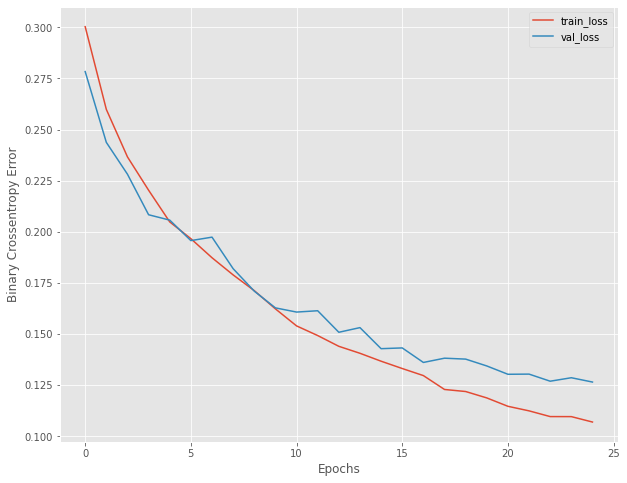

In [ ]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Error')
plt.legend(loc='best')

plt.savefig('./loss.png')
plt.show()

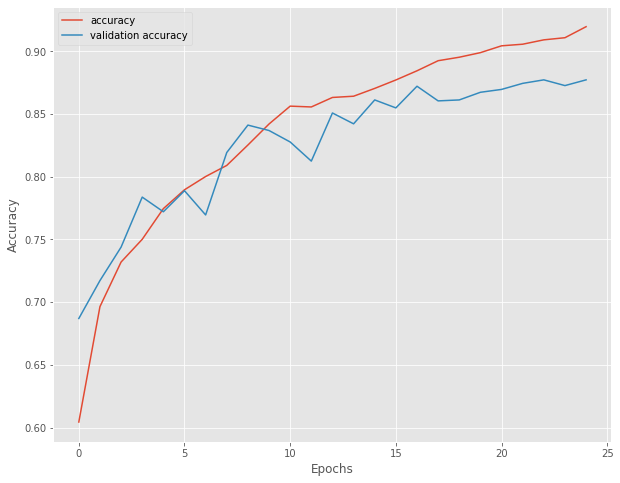

In [ ]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['custom_acc'], label='accuracy')
plt.plot(r.history['val_custom_acc'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.savefig('./acc.png')
plt.show()

In [ ]:
preds = model.predict([pair_val[:,0], pair_val[:,1]])
preds = np.reshape(preds, (preds.shape[0],))
preds = 1.0 - np.round(preds, 0)

In [ ]:
def display_images(no_of_images, image_set, preds, labels):
  if no_of_images > image_set.shape[0]:
    raise ValueError("can only enter no_of_images <= {}".format(image_set.shape[0]))

  preds_index = np.random.randint(0, image_set.shape[0], no_of_images)

  fig = plt.figure(figsize=[20, 15])

  for i,v in enumerate(preds_index):
    p1 = np.squeeze(pair_val[v, 0])
    p2 = np.squeeze(pair_val[v, 1])

    fig.add_subplot(no_of_images,1,i+1)
    plt.plot(p1)
    plt.plot(p2)

    actual_label = "similar" if labels[v] == 1.0 else "dissimilar"
    predicted_label = "similar" if preds[v] == 1.0 else "dissimilar"
    plt.title("actual: {}  predicted: {}". format(actual_label, predicted_label))

  plt.tight_layout()
  plt.show()

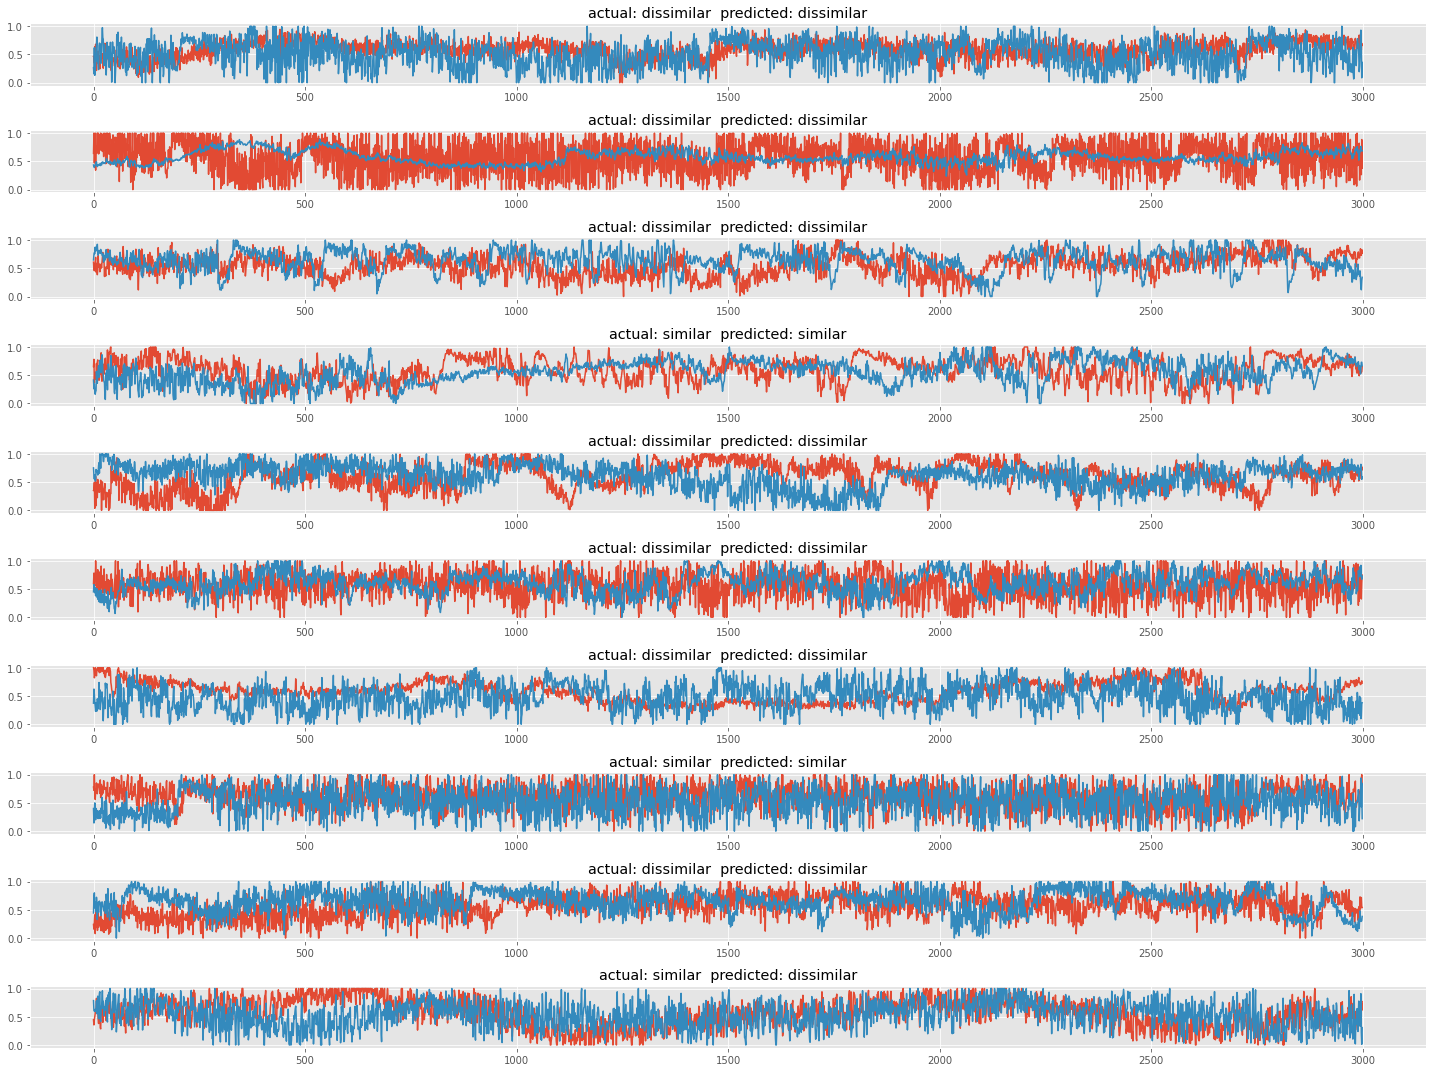

In [ ]:
display_images(10, pair_val, preds, label_val)

In [ ]:
model.save('./siamese_motor_imagery_resnet.h5')

In [ ]:
model.save_weights("./weights.h5")

In [ ]:
import json
with open('data.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)